In [ ]:
import urllib.request
import os
import numpy as np
import csv
import pandas as pd
import itertools
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import re, string
import nltk
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.preprocessing.text import one_hot
from keras import backend as K

from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
df_test = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_test.csv")
df_train = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_train.csv")

#Binary Classification

##Preprocessing

In [ ]:
X_train = df_train['cleaned_text']
y_train = df_train['irony'].values

In [ ]:
X_test = df_test['cleaned_text']
y_test = df_test['irony'].values

In [ ]:
def nltk_ngram_tokenizer(text):
    tt= TweetTokenizer()
    all_tokens = list()

    tokens = tt.tokenize(text)


    # we use a simple nltk function to create ngrams
    if len(tokens) >= 2:
      bigrams = ['BI_'+w1+'_'+w2 for w1,w2 in nltk.ngrams(tokens,2)]
      trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(tokens,3)]
      all_tokens.extend(bigrams)
      all_tokens.extend(trigrams)

    all_tokens.extend(tokens)

    return all_tokens

Train and Test encoding

In [ ]:
X_train_enc= [one_hot(text, 5000, lower=False, split=' ') for text in X_train]
X_test_enc= [one_hot(text, 5000, lower=False, split=' ') for text in X_test]

In [ ]:
X_train = sequence.pad_sequences(X_train_enc, maxlen=200)
X_test = sequence.pad_sequences(X_test_enc, maxlen=200)

Grid implementation

In [ ]:
def grid_search(x_train, y_train, param_grid, fold, epochs, batch_size):
  totale_iter= 1
  for _,value in param_grid.items():
    totale_iter= totale_iter*len(value)

  split= fold.split(x_train, y_train)
  list_split=[]
  for train_index, test_index in split:
    list_split.append([train_index,test_index])
  list_split=np.array(list_split, dtype=object)
  
  iter=0
  cv_results=[]
  for params in itertools.product(*[l for l in param_grid.values()]):
    d= dict(zip(param_grid.keys(), params))
    
    acc=[]
    losses=[]
    tr_loss=[]
    
    for i in range(0,len(list_split)):
      model= build_model(**d)
      x_train_cv, x_val_cv, y_train_cv, y_val_cv=  x_train[list_split[i,0]], x_train[list_split[i,1]], y_train[list_split[i,0]], y_train[list_split[i,1]]

      callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
      res= model.fit(x_train_cv, y_train_cv, epochs=epochs, batch_size=batch_size, 
                 validation_data=(x_val_cv,y_val_cv), verbose=1, callbacks=[callback])
      
      epoche=np.argmin(res.history['val_loss']) 

      losses.append(res.history['val_loss'][epoche])
      acc.append(res.history['val_binary_accuracy'][epoche])
      tr_loss.append(res.history['loss'][epoche])


    mean_acc= np.mean(acc)
    std_acc= np.std(acc)
    d['mean_acc']= mean_acc
    d['std_acc']= std_acc

    mean_loss= np.mean(losses)
    std_loss= np.std(losses)
    d['mean_val_loss']= mean_loss
    d['std_val_loss']= std_loss
    
    mean_loss_tr= np.mean(tr_loss)
    std_loss_tr= np.std(tr_loss)
    d['mean_training_loss']= mean_loss_tr
    d['std_training_loss']= std_loss_tr


    
    cv_results.append(d)
    iter=iter+1
    print('ITERAZIONE NUMERO ' + str(iter)+ '   su '+ str(totale_iter)+ ' totali')
  
  return cv_results

##LSTM

Model building

In [ ]:
def build_model(units, input_dim, output_dim, weight_init, eta, lambd, beta_1, beta_2):

  tf.random.set_seed(0)  

  init= tf.keras.initializers.RandomNormal(mean=0., stddev=weight_init)
  reg= tf.keras.regularizers.l2(l2=lambd)

  model = Sequential()
  model.add(Embedding(input_dim=input_dim, output_dim=output_dim))
  #mandatory hyperparameter to use GPU accelerator
  model.add(LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True, recurrent_dropout=0, dropout=0, 
                 kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg, return_sequences=True))
  model.add(LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True, recurrent_dropout=0, dropout=0, 
                 kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg))
  model.add(Dense(1, activation='sigmoid',kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg))

  opt= tf.keras.optimizers.Adam(learning_rate=eta, beta_1=beta_1, beta_2=beta_2)
  model.compile(loss='binary_crossentropy', 
                optimizer=opt,
                metrics=['binary_accuracy'])

  return model

In [ ]:
param_grid={
    'units': [10, 20, 50], 
    'input_dim': [5000], 
    'output_dim': [20, 50, 100], 
    'eta': [0.01, 0.001, 0.0005], 
    'lambd': [0.1, 0.01, 0.001], 
    'beta_1': [0.9, 0.8, 0.6], 
    'beta_2': [0.999],
    'weight_init': [0.2]
}

In [ ]:
cv_results= grid_search(X_train, y_train, param_grid, fold=StratifiedKFold(n_splits=4, shuffle=True, random_state=0), epochs=300, batch_size=(len(X_train)))

In [ ]:
sorted_result = (sorted(cv_results, key = lambda i: (i['mean_acc'], i['std_acc'])))
best_5_result=sorted_result[:5]
best_5_result

In [ ]:
best_model_par=best_5_result[0]
best_model_par

In [ ]:
best_model_par={'beta_1': 0.9,
 'beta_2': 0.999,
 'eta': 0.01,
 'input_dim': 5000,
 'lambd': 0.001,
 'mean_acc': 0.6296128630638123,
 'mean_training_loss': 0.8968818187713623,
 'mean_val_loss': 1.0611042231321335,
 'output_dim': 100,
 'std_acc': 0.01988522139040745,
 'std_training_loss': 0.1649152262334422,
 'std_val_loss': 0.18852548087055243,
 'units': 50,
 'weight_init': 0.2}

In [ ]:
err=best_model_par['mean_training_loss']
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <=err):
            print("\n\n\nReached tr value so cancelling training!\n\n\n")
            self.model.stop_training = True

In [ ]:
trainingStopCallback = haltCallback()
d=best_model_par
model_best= build_model(units=d['units'], input_dim=d['input_dim'], output_dim=d['output_dim'], weight_init=d['weight_init'], eta=d['eta'], lambd=d['lambd'], beta_1=d['beta_1'], beta_2=d['beta_2'])

val_best=(X_test,y_test)     #plot
result_best=model_best.fit(x=X_train, y=y_train, epochs=300, batch_size=(len(X_train)), validation_data=val_best, 
                           shuffle=True,callbacks=[trainingStopCallback])

Epoch 1/300
1/1 [==============================] - 4s 4s/step - loss: 1.9055 - binary_accuracy: 0.4913 - val_loss: 2.2311 - val_binary_accuracy: 0.4989
Epoch 2/300
1/1 [==============================] - 0s 240ms/step - loss: 2.2058 - binary_accuracy: 0.5087 - val_loss: 1.7830 - val_binary_accuracy: 0.4989
Epoch 3/300
1/1 [==============================] - 0s 235ms/step - loss: 1.7671 - binary_accuracy: 0.5087 - val_loss: 1.6943 - val_binary_accuracy: 0.5011
Epoch 4/300
1/1 [==============================] - 0s 247ms/step - loss: 1.6867 - binary_accuracy: 0.4913 - val_loss: 1.6366 - val_binary_accuracy: 0.5011
Epoch 5/300
1/1 [==============================] - 0s 242ms/step - loss: 1.6245 - binary_accuracy: 0.4913 - val_loss: 1.5579 - val_binary_accuracy: 0.5011
Epoch 6/300
1/1 [==============================] - 0s 234ms/step - loss: 1.5377 - binary_accuracy: 0.4913 - val_loss: 1.4873 - val_binary_accuracy: 0.5378
Epoch 7/300
1/1 [==============================] - 0s 238ms/step - loss: 

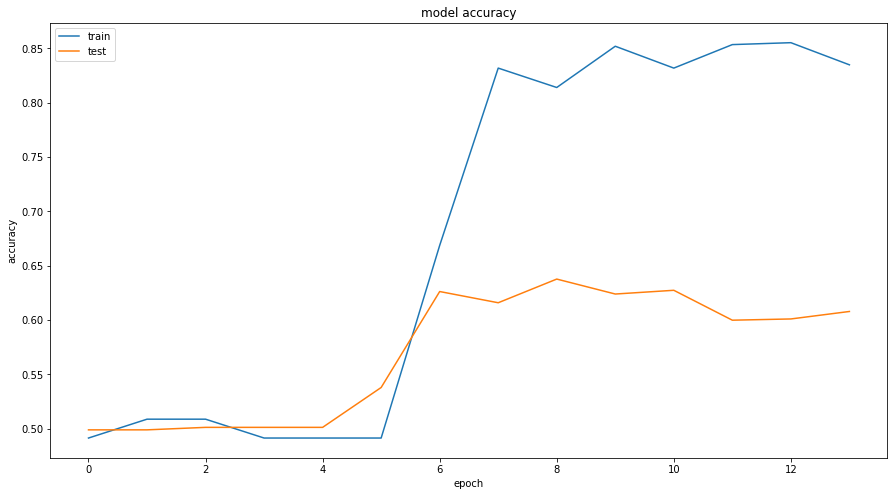

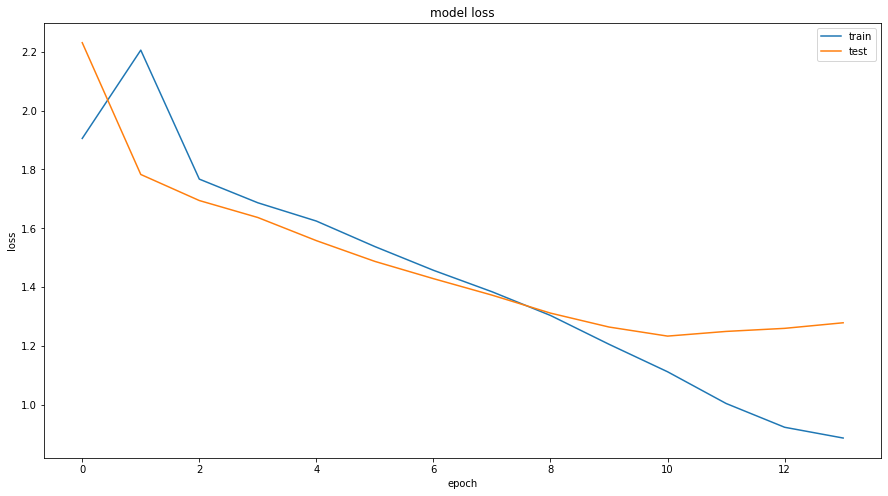

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(result_best.history['binary_accuracy'])
plt.plot(result_best.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))
plt.plot(result_best.history['loss'])
plt.plot(result_best.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
y_proba= model_best.predict(X_train, batch_size=len(X_train))

In [ ]:
y_pred= np.round(y_proba)

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89      1954
         1.0       0.90      0.88      0.89      2023

    accuracy                           0.89      3977
   macro avg       0.89      0.89      0.89      3977
weighted avg       0.89      0.89      0.89      3977



In [ ]:
y_proba_test= model_best.predict(X_test, batch_size=len(X_test))
y_pred_test= np.round(y_proba_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.62      0.55      0.59       437
         1.0       0.60      0.66      0.63       435

    accuracy                           0.61       872
   macro avg       0.61      0.61      0.61       872
weighted avg       0.61      0.61      0.61       872



##Bi-LSTM

In [ ]:
def build_model(units, input_dim, output_dim, weight_init, eta, lambd, beta_1, beta_2):

  tf.random.set_seed(0)  

  init= tf.keras.initializers.RandomNormal(mean=0., stddev=weight_init)
  reg= tf.keras.regularizers.l2(l2=lambd)

  model = Sequential()
  model.add(Embedding(input_dim=input_dim, output_dim=output_dim))
  #mandatory hyperparameter to use GPU accelerator
  model.add(Bidirectional(LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True, recurrent_dropout=0, dropout=0, 
                 kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg, return_sequences=True)))
  model.add(Bidirectional(LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True, recurrent_dropout=0, dropout=0, 
                 kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg)))
  model.add(Dense(1, activation='sigmoid',kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg))

  opt= tf.keras.optimizers.Adam(learning_rate=eta, beta_1=beta_1, beta_2=beta_2)
  model.compile(loss='binary_crossentropy', 
                optimizer=opt,
                metrics=['binary_accuracy'])

  return model

In [ ]:
param_grid={
    'units': [10, 20, 50], 
    'input_dim': [5000], 
    'output_dim': [20, 50, 100], 
    'eta': [0.1, 0.01, 0.0005], 
    'lambd': [0.1, 0.01, 0.001], 
    'beta_1': [0.9, 0.8, 0.6], 
    'beta_2': [0.999],
    'weight_init': [0.2]
}

In [ ]:
cv_results= grid_search(X_train, y_train, param_grid, fold=StratifiedKFold(n_splits=4, shuffle=True, random_state=0), epochs=300, batch_size=(len(X_train)))

In [ ]:
sorted_result = (sorted(cv_results, key = lambda i: (i['mean_acc'], i['std_acc'])))
best_5_result=sorted_result[:5]
best_5_result

In [ ]:
best_model_par=best_5_result[0]
best_model_par

In [ ]:
best_model_par={'beta_1': 0.9,
 'beta_2': 0.999,
 'eta': 0.01,
 'input_dim': 5000,
 'lambd': 0.001,
 'mean_acc': 0.6648231148719788,
 'mean_training_loss': 0.8180886209011078,
 'mean_val_loss': 1.0682262778282166,
 'output_dim': 100,
 'std_acc': 0.004815774726263579,
 'std_training_loss': 0.002767240274272734,
 'std_val_loss': 0.0056346753267225175,
 'units': 20,
 'weight_init': 0.2}

In [ ]:
err=best_model_par['mean_training_loss']
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <=err):
            print("\n\n\nReached tr value so cancelling training!\n\n\n")
            self.model.stop_training = True

In [ ]:
trainingStopCallback = haltCallback()
d=best_model_par
model_best= build_model(units=d['units'], input_dim=d['input_dim'], output_dim=d['output_dim'], weight_init=d['weight_init'], eta=d['eta'], lambd=d['lambd'], beta_1=d['beta_1'], beta_2=d['beta_2'])

val_best=(X_test,y_test)     #plot
result_best=model_best.fit(x=X_train, y=y_train, epochs=300, batch_size=(len(X_train)), validation_data=val_best, 
                           shuffle=True,callbacks=[trainingStopCallback])

Epoch 1/300
1/1 [==============================] - 6s 6s/step - loss: 1.6162 - binary_accuracy: 0.4913 - val_loss: 1.6085 - val_binary_accuracy: 0.4989
Epoch 2/300
1/1 [==============================] - 0s 243ms/step - loss: 1.5966 - binary_accuracy: 0.5087 - val_loss: 1.4954 - val_binary_accuracy: 0.4989
Epoch 3/300
1/1 [==============================] - 0s 242ms/step - loss: 1.4809 - binary_accuracy: 0.5087 - val_loss: 1.4201 - val_binary_accuracy: 0.6193
Epoch 4/300
1/1 [==============================] - 0s 241ms/step - loss: 1.4027 - binary_accuracy: 0.8190 - val_loss: 1.3721 - val_binary_accuracy: 0.5011
Epoch 5/300
1/1 [==============================] - 0s 281ms/step - loss: 1.3481 - binary_accuracy: 0.4933 - val_loss: 1.3191 - val_binary_accuracy: 0.5034
Epoch 6/300
1/1 [==============================] - 0s 241ms/step - loss: 1.2817 - binary_accuracy: 0.5270 - val_loss: 1.2584 - val_binary_accuracy: 0.5734
Epoch 7/300
1/1 [==============================] - 0s 243ms/step - loss: 

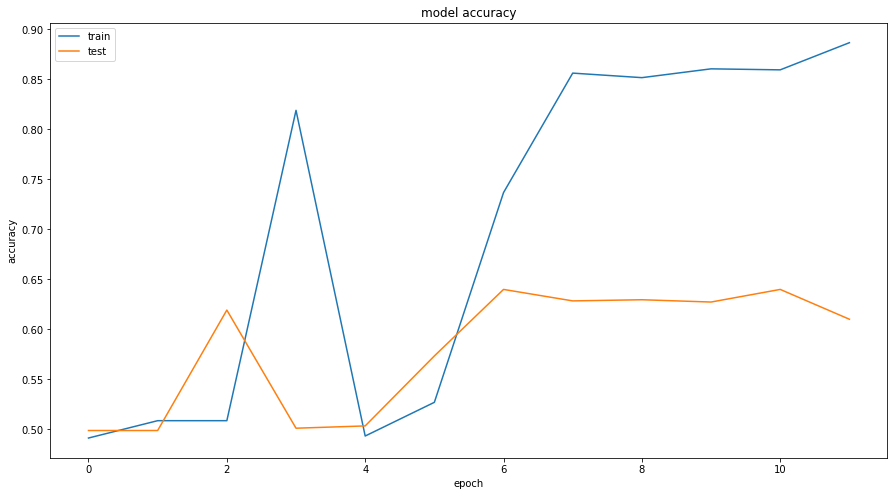

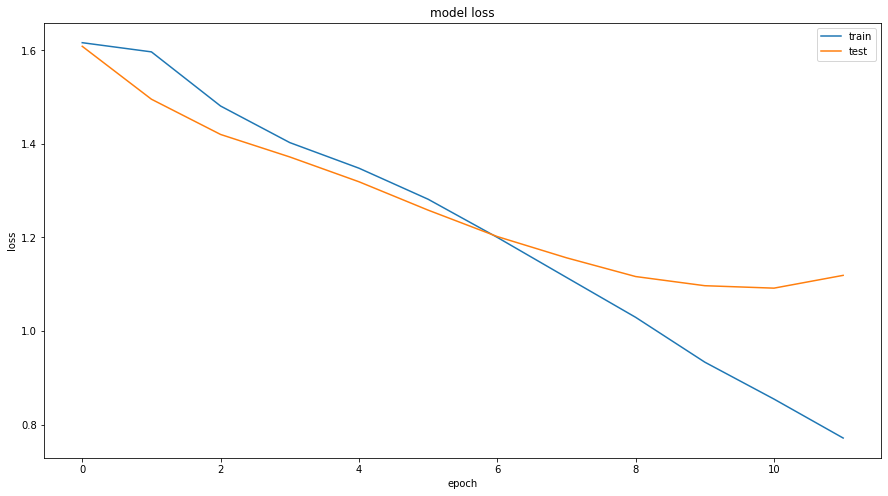

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(result_best.history['binary_accuracy'])
plt.plot(result_best.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))
plt.plot(result_best.history['loss'])
plt.plot(result_best.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
y_proba= model_best.predict(X_train, batch_size=len(X_train))

In [ ]:
y_pred= np.round(y_proba)

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      1954
         1.0       0.84      0.96      0.90      2023

    accuracy                           0.89      3977
   macro avg       0.90      0.89      0.89      3977
weighted avg       0.90      0.89      0.89      3977



In [ ]:
y_proba_test= model_best.predict(X_test, batch_size=len(X_test))
y_pred_test= np.round(y_proba_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.68      0.43      0.52       437
         1.0       0.58      0.80      0.67       435

    accuracy                           0.61       872
   macro avg       0.63      0.61      0.60       872
weighted avg       0.63      0.61      0.60       872



#Multiclass Classification

##Preprocessing

In [ ]:
X_train = df_train['cleaned_text']
y_train = df_train[['irony','sarcasm']].values.sum(axis=1)

In [ ]:
X_test = df_test['cleaned_text']
y_test = df_test[['irony','sarcasm']].values.sum(axis=1)

In [ ]:
X_train_enc= [one_hot(text, 5000, lower=False, split=' ') for text in X_train]
X_test_enc= [one_hot(text, 5000, lower=False, split=' ') for text in X_test]

In [ ]:
X_train = sequence.pad_sequences(X_train_enc, maxlen=200)
X_test = sequence.pad_sequences(X_test_enc, maxlen=200)

In [ ]:
def grid_search(x_train, y_train, param_grid, fold, epochs, batch_size):
  totale_iter= 1
  for _,value in param_grid.items():
    totale_iter= totale_iter*len(value)

  split= fold.split(x_train, y_train)
  list_split=[]
  for train_index, test_index in split:
    list_split.append([train_index,test_index])
  list_split=np.array(list_split, dtype=object)
  
  iter=0
  cv_results=[]
  for params in itertools.product(*[l for l in param_grid.values()]):
    d= dict(zip(param_grid.keys(), params))
    
    acc=[]
    losses=[]
    tr_loss=[]
    
    for i in range(0,len(list_split)):
      model= build_model(**d)
      x_train_cv, x_val_cv, y_train_cv, y_val_cv=  x_train[list_split[i,0]], x_train[list_split[i,1]], y_train[list_split[i,0]], y_train[list_split[i,1]]

      callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
      res= model.fit(x_train_cv, y_train_cv, epochs=epochs, batch_size=batch_size, 
                 validation_data=(x_val_cv,y_val_cv), verbose=1, callbacks=[callback])
      
      epoche=np.argmin(res.history['val_loss']) 

      losses.append(res.history['val_loss'][epoche])
      acc.append(res.history['val_sparse_categorical_accuracy'][epoche])
      tr_loss.append(res.history['loss'][epoche])


    mean_acc= np.mean(acc)
    std_acc= np.std(acc)
    d['mean_acc']= mean_acc
    d['std_acc']= std_acc

    mean_loss= np.mean(losses)
    std_loss= np.std(losses)
    d['mean_val_loss']= mean_loss
    d['std_val_loss']= std_loss
    
    mean_loss_tr= np.mean(tr_loss)
    std_loss_tr= np.std(tr_loss)
    d['mean_training_loss']= mean_loss_tr
    d['std_training_loss']= std_loss_tr


    
    cv_results.append(d)
    iter=iter+1
    print('ITERAZIONE NUMERO ' + str(iter)+ '   su '+ str(totale_iter)+ ' totali')
  
  return cv_results

##LSTM

In [ ]:
def build_model(units, input_dim, output_dim, weight_init, eta, lambd, beta_1, beta_2):

  tf.random.set_seed(0)  

  init= tf.keras.initializers.RandomNormal(mean=0., stddev=weight_init)
  reg= tf.keras.regularizers.l2(l2=lambd)

  model = Sequential()
  model.add(Embedding(input_dim=input_dim, output_dim=output_dim))
  #mandatory hyperparameter to use GPU accelerator
  model.add(LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True, recurrent_dropout=0, dropout=0, 
                 kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg, return_sequences=True))
  model.add(LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True, recurrent_dropout=0, dropout=0, 
                 kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg))
  model.add(Dense(3, activation='softmax',kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg))

  opt= tf.keras.optimizers.Adam(learning_rate=eta, beta_1=beta_1, beta_2=beta_2)
  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=opt,
                metrics=['sparse_categorical_accuracy'])

  return model

In [ ]:
param_grid={
    'units': [10, 20, 50], 
    'input_dim': [5000], 
    'output_dim': [20, 50, 100], 
    'eta': [0.01, 0.001, 0.0005], 
    'lambd': [0.1, 0.01, 0.001], 
    'beta_1': [0.9, 0.8, 0.6], 
    'beta_2': [0.999],
    'weight_init': [0.2]
}

In [ ]:
cv_results= grid_search(X_train, y_train, param_grid, fold=StratifiedKFold(n_splits=4, shuffle=True, random_state=0), epochs=300, batch_size=(len(X_train)))

In [ ]:
sorted_result = (sorted(cv_results, key = lambda i: (i['mean_acc'], i['std_acc'])))
best_5_result=sorted_result[:5]
best_5_result

In [ ]:
best_model_par=best_5_result[0]
best_model_par

In [ ]:
best_model_par={'beta_1': 0.8,
 'beta_2': 0.999,
 'eta': 0.01,
 'input_dim': 5000,
 'lambd': 0.001,
 'mean_acc': 0.5008839517831802,
 'mean_training_loss': 0.9037539213895798,
 'mean_val_loss': 1.4641973972320557,
 'output_dim': 50,
 'std_acc': 0.013372527345228053,
 'std_training_loss': 0.049590653359750964,
 'std_val_loss': 0.022589529372136673,
 'units': 50,
 'weight_init': 0.2}

In [ ]:
err=best_model_par['mean_training_loss']
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <=err):
            print("\n\n\nReached tr value so cancelling training!\n\n\n")
            self.model.stop_training = True

In [ ]:
trainingStopCallback = haltCallback()
d=best_model_par
model_best= build_model(units=d['units'], input_dim=d['input_dim'], output_dim=d['output_dim'], weight_init=d['weight_init'], eta=d['eta'], lambd=d['lambd'], beta_1=d['beta_1'], beta_2=d['beta_2'])

val_best=(X_test,y_test)     #plot
result_best=model_best.fit(x=X_train, y=y_train, epochs=300, batch_size=(len(X_train)), validation_data=val_best, 
                           shuffle=True,callbacks=[trainingStopCallback])

Epoch 1/300
1/1 [==============================] - 7s 7s/step - loss: 3.6182 - sparse_categorical_accuracy: 0.2296 - val_loss: 4.4111 - val_sparse_categorical_accuracy: 0.5011
Epoch 2/300
1/1 [==============================] - 0s 463ms/step - loss: 4.3933 - sparse_categorical_accuracy: 0.4913 - val_loss: 4.1420 - val_sparse_categorical_accuracy: 0.2511
Epoch 3/300
1/1 [==============================] - 0s 464ms/step - loss: 4.0548 - sparse_categorical_accuracy: 0.2791 - val_loss: 3.3924 - val_sparse_categorical_accuracy: 0.2511
Epoch 4/300
1/1 [==============================] - 0s 462ms/step - loss: 3.3444 - sparse_categorical_accuracy: 0.2791 - val_loss: 3.0987 - val_sparse_categorical_accuracy: 0.5011
Epoch 5/300
1/1 [==============================] - 0s 463ms/step - loss: 3.0847 - sparse_categorical_accuracy: 0.4913 - val_loss: 3.0010 - val_sparse_categorical_accuracy: 0.5011
Epoch 6/300
1/1 [==============================] - 0s 464ms/step - loss: 3.0067 - sparse_categorical_accurac

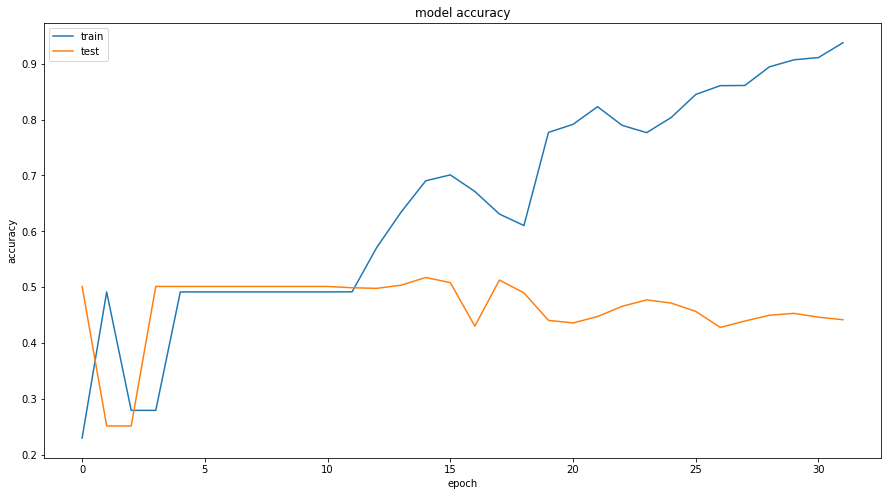

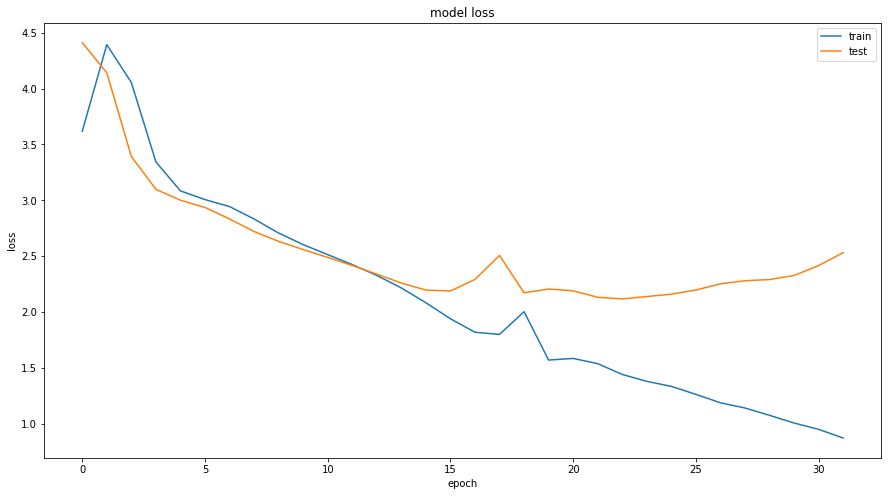

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(result_best.history['sparse_categorical_accuracy'])
plt.plot(result_best.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))
plt.plot(result_best.history['loss'])
plt.plot(result_best.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
y_proba= model_best.predict(X_train, batch_size=len(X_train))

In [ ]:
y_pred= np.argmax(y_proba, axis=1)

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1954
         1.0       0.94      0.85      0.89      1110
         2.0       0.84      0.95      0.89       913

    accuracy                           0.94      3977
   macro avg       0.92      0.93      0.92      3977
weighted avg       0.94      0.94      0.94      3977



In [ ]:
y_proba_test= model_best.predict(X_test, batch_size=len(X_test))
y_pred_test= np.argmax(y_proba_test, axis=1)

In [ ]:
print(classification_report(y_test, y_pred_test, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.57      0.53      0.55       437
         1.0       0.31      0.30      0.30       219
         2.0       0.34      0.40      0.37       216

    accuracy                           0.44       872
   macro avg       0.41      0.41      0.41       872
weighted avg       0.45      0.44      0.44       872



##Bi-LSTM

In [ ]:
def build_model(units, input_dim, output_dim, weight_init, eta, lambd, beta_1, beta_2):

  tf.random.set_seed(0)  

  init= tf.keras.initializers.RandomNormal(mean=0., stddev=weight_init)
  reg= tf.keras.regularizers.l2(l2=lambd)

  model = Sequential()
  model.add(Embedding(input_dim=input_dim, output_dim=output_dim))
  #mandatory hyperparameter to use GPU accelerator
  model.add(Bidirectional(LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True, recurrent_dropout=0, dropout=0, 
                 kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg, return_sequences=True)))
  model.add(Bidirectional(LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True, recurrent_dropout=0, dropout=0, 
                 kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg)))
  model.add(Dense(3, activation='softmax',kernel_initializer=init, bias_initializer=init, kernel_regularizer=reg))

  opt= tf.keras.optimizers.Adam(learning_rate=eta, beta_1=beta_1, beta_2=beta_2)
  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=opt,
                metrics=['sparse_categorical_accuracy'])

  return model

In [ ]:
param_grid={
    'units': [10, 20, 50], 
    'input_dim': [5000], 
    'output_dim': [20, 50, 100], 
    'eta': [0.01, 0.001, 0.0005], 
    'lambd': [0.1, 0.01, 0.001], 
    'beta_1': [0.9, 0.8, 0.6], 
    'beta_2': [0.999],
    'weight_init': [0.2]
}

In [ ]:
cv_results= grid_search(X_train, y_train, param_grid, fold=StratifiedKFold(n_splits=4, shuffle=True, random_state=0), epochs=300, batch_size=(len(X_train)))

In [ ]:
sorted_result = (sorted(cv_results, key = lambda i: (i['mean_acc'], i['std_acc'])))
best_5_result=sorted_result[:5]
best_5_result

In [ ]:
best_model_par=best_5_result[0]
best_model_par

In [ ]:
best_model_par={'beta_1': 0.8,
 'beta_2': 0.999,
 'eta': 0.01,
 'input_dim': 5000,
 'lambd': 0.001,
 'mean_acc': 0.5247682183980942,
 'mean_training_loss': 0.8270650506019592,
 'mean_val_loss': 1.1567567586898804,
 'output_dim': 20,
 'std_acc': 0.007757291930121476,
 'std_training_loss': 0.028315434050869337,
 'std_val_loss': 0.008243414314351001,
 'units': 20,
 'weight_init': 0.2}

In [ ]:
err=best_model_par['mean_training_loss']
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <=err):
            print("\n\n\nReached tr value so cancelling training!\n\n\n")
            self.model.stop_training = True

In [ ]:
trainingStopCallback = haltCallback()
d=best_model_par
model_best= build_model(units=d['units'], input_dim=d['input_dim'], output_dim=d['output_dim'], weight_init=d['weight_init'], eta=d['eta'], lambd=d['lambd'], beta_1=d['beta_1'], beta_2=d['beta_2'])

val_best=(X_test,y_test)     #plot
result_best=model_best.fit(x=X_train, y=y_train, epochs=300, batch_size=(len(X_train)), validation_data=val_best, 
                           shuffle=True,callbacks=[trainingStopCallback])

Epoch 1/300
1/1 [==============================] - 12s 12s/step - loss: 1.5016 - sparse_categorical_accuracy: 0.2791 - val_loss: 1.4535 - val_sparse_categorical_accuracy: 0.5011
Epoch 2/300
1/1 [==============================] - 0s 277ms/step - loss: 1.4560 - sparse_categorical_accuracy: 0.4913 - val_loss: 1.4073 - val_sparse_categorical_accuracy: 0.5011
Epoch 3/300
1/1 [==============================] - 0s 219ms/step - loss: 1.4069 - sparse_categorical_accuracy: 0.4913 - val_loss: 1.3773 - val_sparse_categorical_accuracy: 0.5011
Epoch 4/300
1/1 [==============================] - 0s 229ms/step - loss: 1.3731 - sparse_categorical_accuracy: 0.4913 - val_loss: 1.3643 - val_sparse_categorical_accuracy: 0.5011
Epoch 5/300
1/1 [==============================] - 0s 200ms/step - loss: 1.3571 - sparse_categorical_accuracy: 0.4913 - val_loss: 1.3420 - val_sparse_categorical_accuracy: 0.5011
Epoch 6/300
1/1 [==============================] - 0s 237ms/step - loss: 1.3317 - sparse_categorical_accur

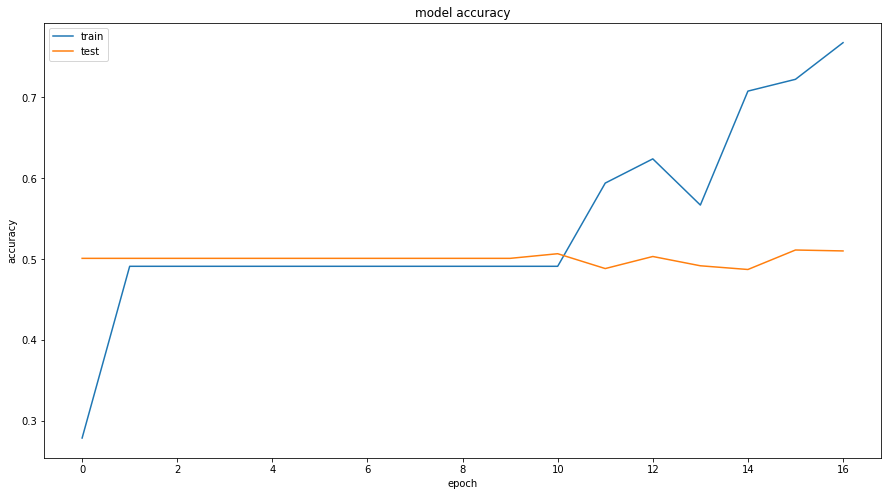

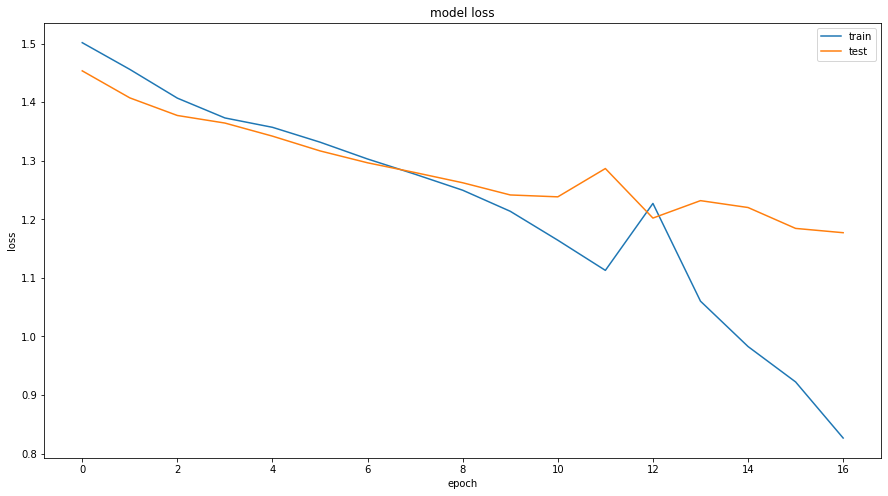

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(result_best.history['sparse_categorical_accuracy'])
plt.plot(result_best.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))
plt.plot(result_best.history['loss'])
plt.plot(result_best.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
y_proba= model_best.predict(X_train, batch_size=len(X_train))

In [ ]:
y_pred= np.argmax(y_proba, axis=1)

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.95      0.88      1954
         1.0       0.89      0.79      0.83      1110
         2.0       0.87      0.72      0.79       913

    accuracy                           0.85      3977
   macro avg       0.86      0.82      0.83      3977
weighted avg       0.85      0.85      0.85      3977



In [ ]:
y_proba_test= model_best.predict(X_test, batch_size=len(X_test))
y_pred_test= np.argmax(y_proba_test, axis=1)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67       437
         1.0       0.31      0.27      0.29       219
         2.0       0.42      0.27      0.33       216

    accuracy                           0.51       872
   macro avg       0.44      0.43      0.43       872
weighted avg       0.48      0.51      0.49       872

